In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos, scale_model_obs
from climpyrical.mask import gen_raster_mask_from_vector, gen_upper_archipelago_mask, stratify_coords
import climpyrical.spytialProcess as sp
from climpyrical.rkrig import krigit_north, rkrig_r

from pkg_resources import resource_filename

from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")


%load_ext autoreload
%autoreload 2

In [2]:
# station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'
# station_dv = 'TJan1.0 (degC)'
# station_dv = 'HDD (degC-day)'
# station_dv = 'Q10_Gumbel-MM'
station_dv = 'Q50_Gumbel-MM'

file_dv = station_dv.split(' ')[0]

OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    f'nrc_data/processed/{file_dv}_pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
dv = list(ds.data_vars)[0]
mask = xr.open_dataset(MASK_PATH)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

In [3]:
file_dv = station_dv.split(' ')[0]
df_path = resource_filename('climpyrical', f'nrc_data/processed/{file_dv}_processed_station.csv')

df = pd.read_csv(df_path, index_col=False)
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

In [4]:
alert_rlon, alert_rlat = 5.279164, 36.203886
alert_lon, alert_lat = -62.3333, 82.5

In [5]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

In [6]:
df.head(3)

,ilocy,ilocx,Q50_Gumbel-MM,rlat,rlon,lat,lon,station_name,ratio,model_vals
0,558,1009,0.351,-4.286303,10.373534,42.276111,-82.955278,WINDSOR A,0.858542,0.362415
1,576,1016,0.384,-3.488044,10.709117,42.999444,-82.308889,SARNIA,0.898521,0.378847
2,579,1050,0.394,-3.335369,12.206823,42.850000,-80.266667,SIMCOE,0.741747,0.470870


# Krig the station only values in the north

In [7]:
path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
northern_mask = gen_upper_archipelago_mask(canada, ds.rlon.values, ds.rlat.values, 210, dsold_max)

# dummy array to force 14 nearest stations to Alert 
alert_arr = [[1472, 894, 235.85, 36.20388623771783, 5.279164142263307,
        82.5, -62.3333, 'ALERT CLIMATE', 1.0091788499249528,
        234.48550962410286, 1.0033403304071171]]

temp_infill = True
if temp_infill:
    if (np.any(df.station_name.str.contains('ALERT')) or 
        np.any(df.station_name.str.contains('alert')) and 
        df.rlat.values > 36.0):

        print("Include ALERT")
        station_final_north_UAA = ~np.isnan(krigit_north(df, station_dv, 15, ds, extrap=False))

    else:
        # Add in the coords for alert
        print("No ALERT. Adding place holder.")
        df_cp = df.append(pd.DataFrame(alert_arr, columns=df.columns))
        station_final_north_UAA = ~np.isnan(krigit_north(df_cp, station_dv, 15, ds, extrap=False))
else:
    station_final_north = krigit_north(df, station_dv, 15, ds, extrap=True)
    station_final_north[~northern_mask] = np.nan

    north_nan = ~np.isnan(station_final_north)
    missed_station_only = (northern_mask^north_nan)

    station_final_north[~northern_mask] = np.nan

    f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

    station_final_north_filled = station_final_north.copy()
    station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
    station_final_north_filled[~northern_mask] = np.nan

UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])

100%|██████████| 59147/59147 [00:08<00:00, 7158.93it/s]


Include ALERT


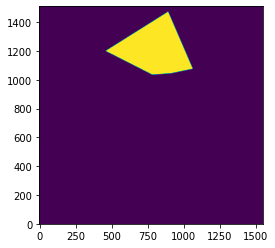

In [8]:
# plt.imshow(northern_mask, origin='lower')
plt.imshow(station_final_north_UAA, origin='lower')

## Find areas in north that are not covered by station only reconstruction

In [9]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [10]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]

station_vals = df[station_dv].values
ratio, best_tol = scale_model_obs(model_vals, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

print(best_tol)

0.8864630048603299


In [11]:
np.seterr(divide='ignore', invalid='ignore')
ratio = rkrig_r(df_south, 30, ds, station_dv)
ratio[~mask] = np.nan

 29%|██▊       | 103/359 [01:26<04:31,  1.06s/it]R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’

In [12]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

<AxesSubplot:ylabel='Count'>

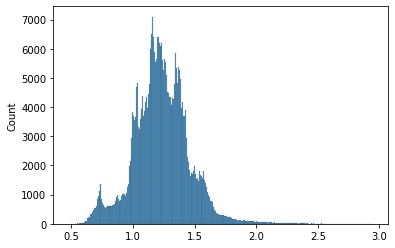

In [13]:
import seaborn as sns
sns.histplot(ratio[~np.isnan(ratio)])

In [14]:
X, Y = stratify_coords(canada)

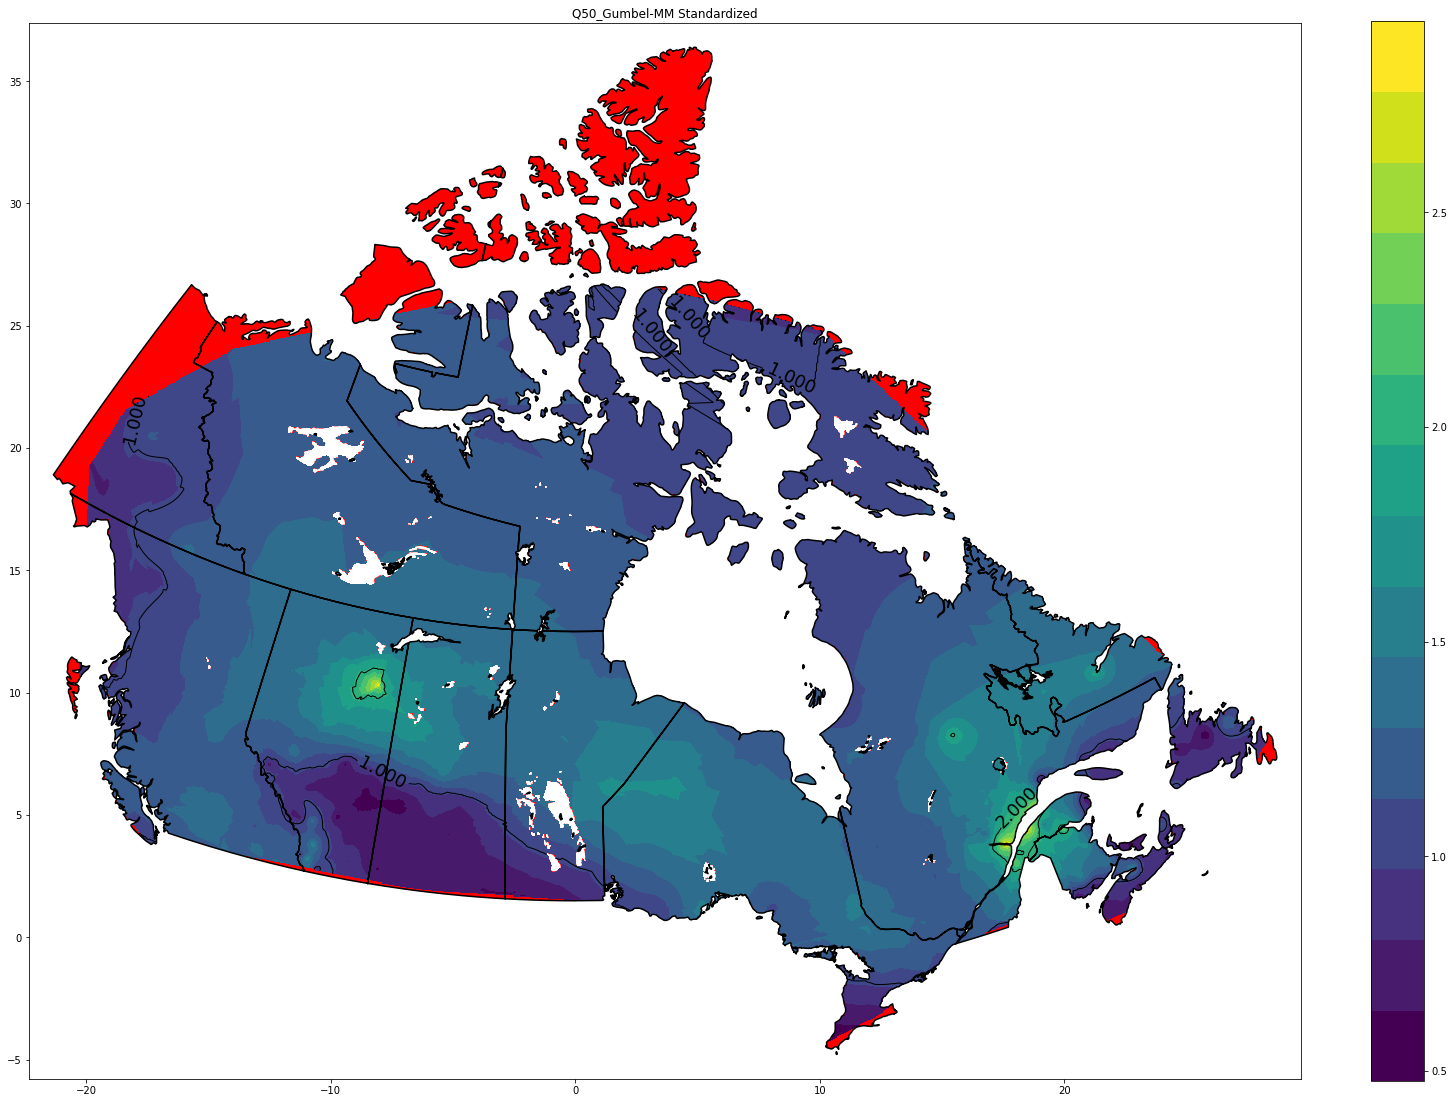

In [15]:
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

ratio = np.array(ratio, dtype=np.float)

fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
# vmin = 5
vmin = 0
vmax = 3


N = 15
cont = np.arange(vmin, vmax, 1)

col1 = ax.imshow(ratio, origin='lower', extent=extent, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Standardized')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/standardized-{station_dv}-Z-full-reconstruction-patched.png')

In [16]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])
ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected.copy()

meancopynorth = ds[dv].values.copy()
meancopynorth[northern_mask] = np.nan

ratio_final_sample_mask = np.logical_and(station_final_north_UAA, ~np.isnan(meancopynorth))
ratio_final_mean_overlap_area = np.nanmean(ratio_final[ratio_final_sample_mask])

combined_ratio_station_mean = np.mean([ratio_final_mean_overlap_area, UAA_station_mean])

# Create a final field
if 'RL50' in station_dv:
    print("North = 0.0")
    ratio_final[northern_mask] = 0.0    
else:
    print("North = mean of overlap")
    ratio_final[northern_mask] = combined_ratio_station_mean

if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("subtracted!")
    ratio_final -= 273.15
    df[station_dv] = df[station_dv] - 273.15


print(combined_ratio_station_mean, ratio_final_mean_overlap_area)
df.head(5)

North = mean of overlap
0.5636851989837846 0.5267037313009024


,ilocy,ilocx,Q50_Gumbel-MM,rlat,rlon,lat,lon,station_name,ratio,model_vals
0,558,1009,0.351,-4.286303,10.373534,42.276111,-82.955278,WINDSOR A,0.858542,0.362415
1,576,1016,0.384,-3.488044,10.709117,42.999444,-82.308889,SARNIA,0.898521,0.378847
2,579,1050,0.394,-3.335369,12.206823,42.850000,-80.266667,SIMCOE,0.741747,0.470870
3,580,1035,0.351,-3.290417,11.534369,43.033056,-81.151111,LONDON A,0.719310,0.432565
4,587,1054,0.441,-2.967246,12.374482,43.173611,-79.935000,HAMILTON A,0.920210,0.424827


In [17]:
from climpyrical.data import gen_dataset

recon_ds = gen_dataset(dv, ratio_final, ds.rlon, ds.rlat)
recon_ds.to_netcdf(f'/home/nannau/dash-dv-explorer/assets/data/reconstructions/{file_dv}_reconstruction.nc')

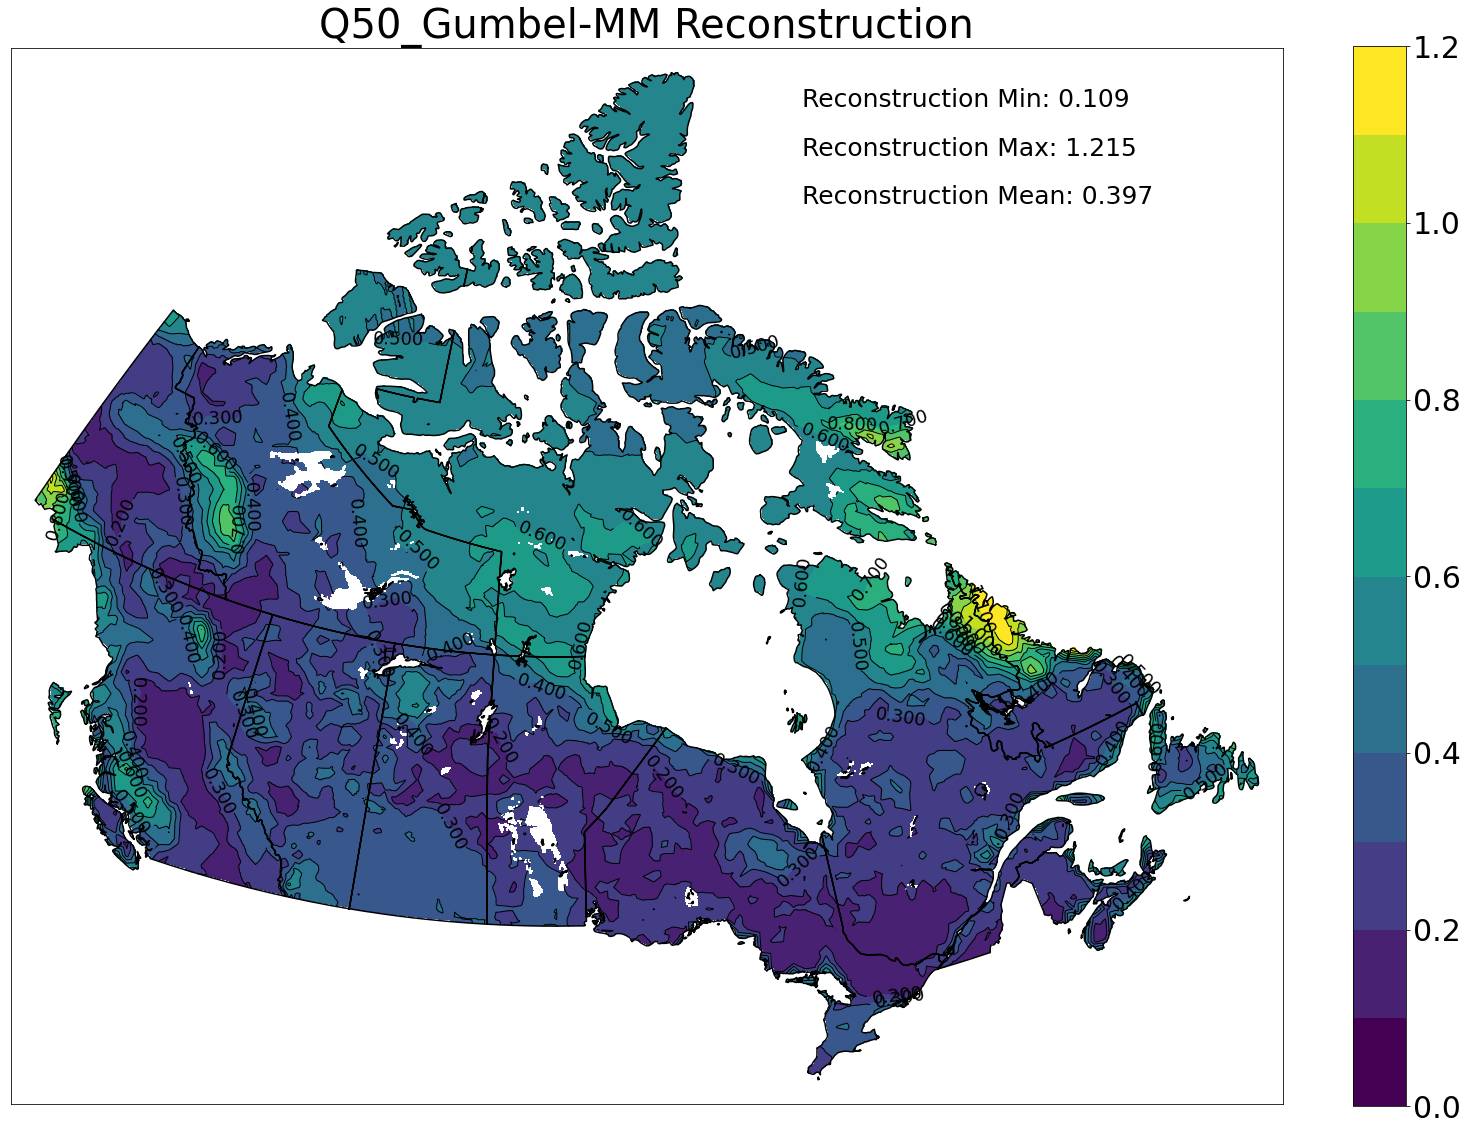

In [20]:
font = {'weight' : 'bold',
        'size'   : 25}

ratio_final[~mask] = np.nan


# vmin, vmax, number of colours, contour interval
plot_dict = {
    'RL50 (kPa)': (0, 1.2, 12, 0.1),
    'mean RH (%)': (50, 100, 10, 5),
    'HDD (degC-day)': (1000, 15000, 15, 1000),
    'SL50 (kPa)': (0, 15, 15, 1),
    'Q10_Gumbel-MM': (0, 0.8, 8, 0.1),
    'Q50_Gumbel-MM': (0, 1.2, 12, 0.1),
    'TJan2.5 (degC)': (-50, 10, 12, 6),
    'TJan1.0 (degC)': (-50, 10, 12, 6)
}

vmin, vmax, N, n_cont = plot_dict[station_dv]

cont = np.arange(vmin, vmax, n_cont)

fig, ax = plt.subplots(figsize=(25, 25))

ax.text(10, 35, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)), fontsize=25)
ax.text(10, 33, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)), fontsize=25)
ax.text(10, 31, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)), fontsize=25)

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)
cbar.ax.tick_params(labelsize=30)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+f' Reconstruction', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}-reconstruction.png')
plt.show()

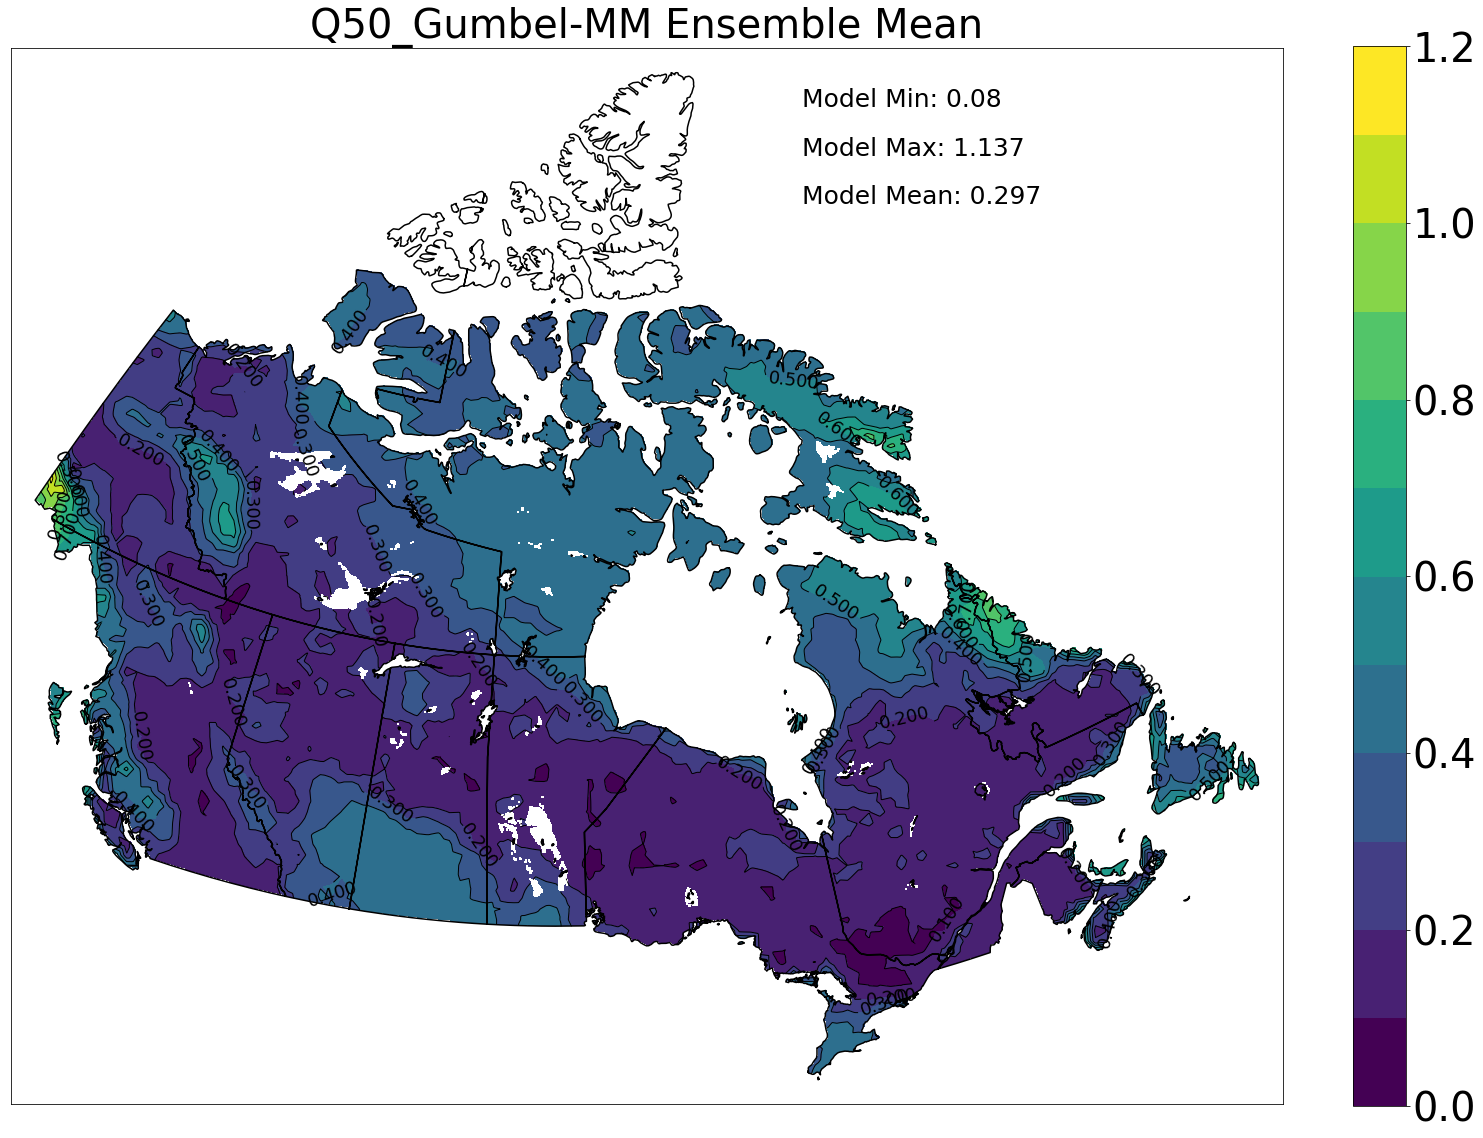

In [21]:
mean = ds[dv].values.copy()
mean[~mask] = np.nan
mean[northern_mask] = np.nan

if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("subtracted!")
    mean -= 273.15

fig, ax = plt.subplots(figsize=(25, 25))

col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.text(10, 35, 'Model Min: {}'.format(np.round(np.nanmin(mean[mask]), 3)), fontsize=25)
ax.text(10, 33, 'Model Max: {}'.format(np.round(np.nanmax(mean[mask]), 3)), fontsize=25)
ax.text(10, 31, 'Model Mean: {}'.format(np.round(np.nanmean(mean[mask]), 3)), fontsize=25)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

cbar.ax.tick_params(labelsize=40)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_CanRCM4_ensmean.png')
plt.show()

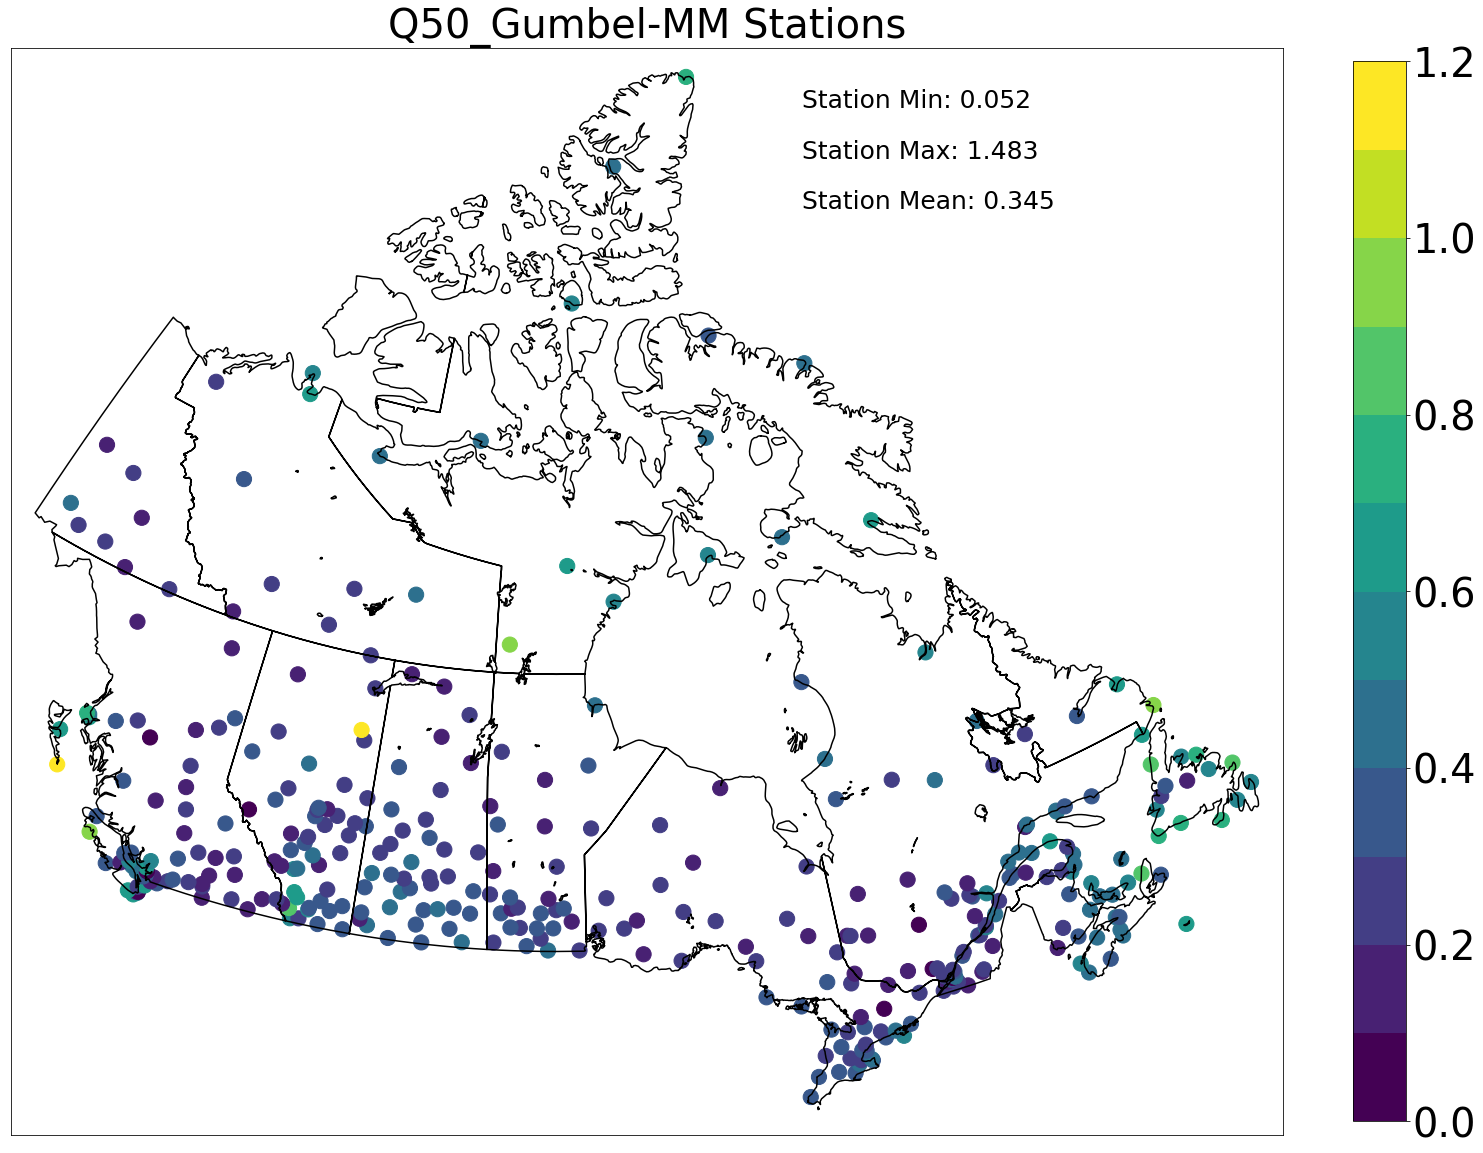

In [22]:
fig, ax = plt.subplots(figsize=(25, 20))

station_vals_deg_c = df[station_dv]
sc = ax.scatter(df.rlon, df.rlat, c = station_vals_deg_c, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
cbar = plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)
cbar.ax.tick_params(labelsize=40)

ax.text(10, 35, 'Station Min: {}'.format(np.round(np.min(station_vals_deg_c), 3)), fontsize=25)
ax.text(10, 33, 'Station Max: {}'.format(np.max(station_vals_deg_c)), fontsize=25)
ax.text(10, 31, 'Station Mean: {}'.format(np.round(np.nanmean(station_vals_deg_c), 3)), fontsize=25)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(station_dv+' Stations', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_stations.png')

In [23]:
np.any(mean[mean < 0 ]), np.any(ratio_final[ratio_final < 0 ])

(False, False)

# Write to Table C-2


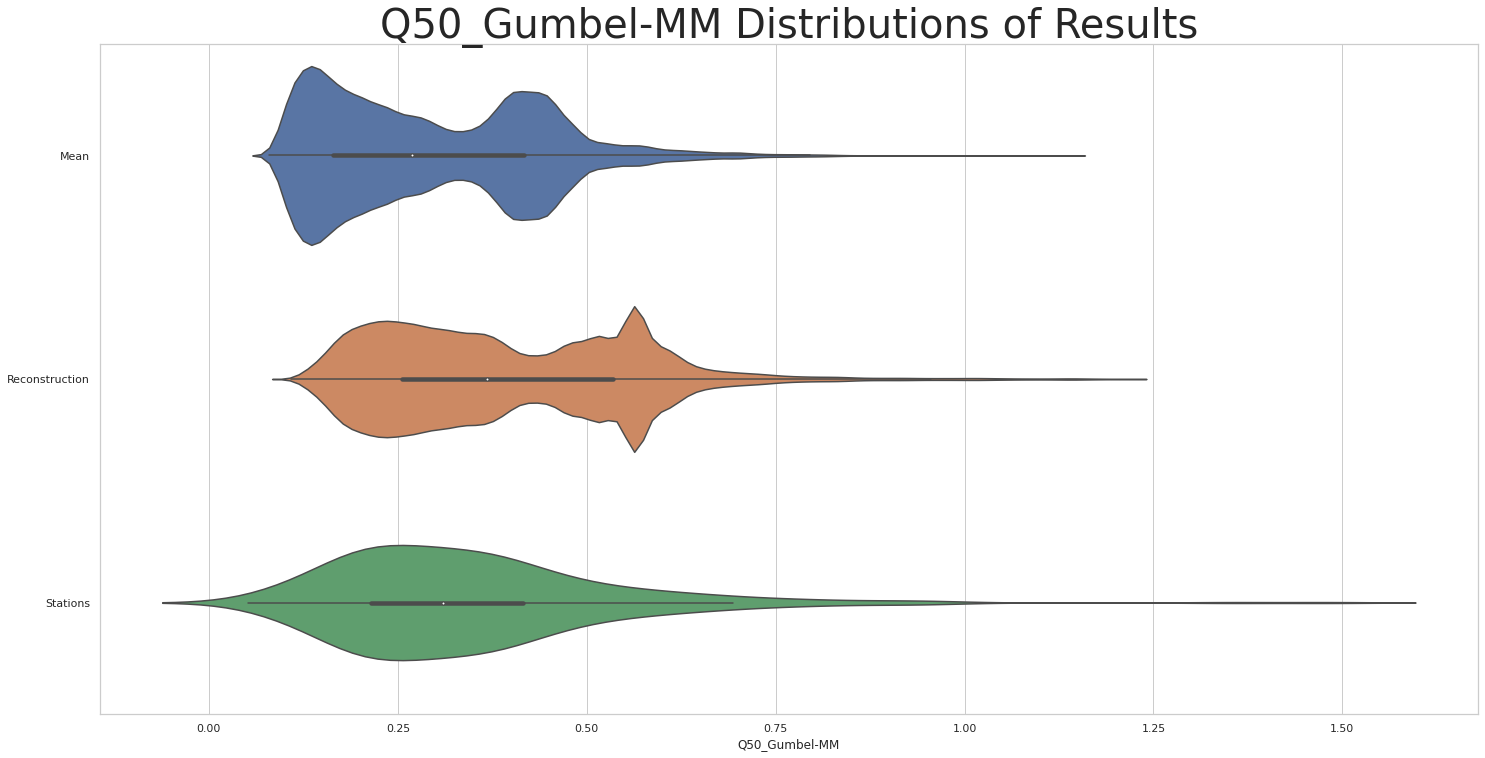

In [24]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20, 10))

violindata = np.concatenate([mean.flatten(), ratio_final.flatten(), station_vals_deg_c])

means_str = ["Mean" for x in mean.flatten()]
ratio_str = ["Reconstruction" for x in ratio_final.flatten()]
station_str = ["Stations" for x in station_vals_deg_c]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{station_dv} Distributions of Results", fontsize=40)
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf)

plt.savefig(f'./data/reporting/{file_dv}-violin.png', bbox_inches='tight')

In [25]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table[station_dv] = design_value
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/reporting/"+file_dv+"TableC2.csv", index=False)
nrc_table.round(3).to_csv("~/dash-dv-explorer/assets/data/tables/"+file_dv+"TableC2.csv", index=False)

In [26]:
!pwd
!source upload_files.sh

/home/nannau/09092020/climpyrical/notebooks/dev

Welcome to PCIC compute! Please use your Netlink ID to login.


Welcome to PCIC compute! Please use your Netlink ID to login.

